# Proyecto en Grupo – Regresión Avanzada<br>*Predicción de Precios de Bienes Raíces en Australia*

### Integrantes:

- Carlos Andrés Pérez Guzmán
- Adad Flores
- Nadir Rodriguez
- Ivan Castillo Fernandez (ivancastillofer@hotmail.com)

# Tabla de Contenido

1. [Introduccion](#Introduccion)
2. [Configuracion e Instalacion](#Configuracion-e-Instalacion)
3. [Entendimiento de los Datos](#Entendimiento-de-los-Datos)  
4. [Manipulacion y Limpieza de Datos](#Manipulacion-y-Limpieza-de-Datos)
    1. [Dropping Data](#Dropping-Data)
    2. [Derived Data](#Derived-Data)
5. [Analisis de Datos](#Analisis-de-Datos)
    1. [Analisis-Univariable](#Analisis-Univariable)
        1. [Plot Numeric Data](#Plot-Numeric-Data)
        2. [Plot Categorical Data](#Plot-Categorical-Data)
    2. [Analisis-Bivariable](#Analisis-Bivariable)
    2. [Analisis-Multivariable](#Analisis-Multivariable)
6. [Preparacion de Datos y Modelado](#Preparacion-de-Datos-y-Modelado)
    1. [Splitting data into Train Test](#Splitting-data-into-Train-Test)
7. [Construccion-del-Modelo](#Model-Building)
    1. [Linear Regression](#Ridge-Regression)
    2. [Ridge Regression](#Lasso-Regression)
    3. [Lasso Regression](#ElasticNet-Regression)
    4. [ElasticNet Regression](#ElasticNet-Regression)
8. [Conclusions y Observaciones](#Conclusiones-y-Observaciones)

# 1. Introducción

En el mercado inmobiliario australiano es caracterizado por su alta competitividad y variabilidad, la estimación precisa de los precios de las viviendas resulta fundamental para orientar decisiones comerciales y de inversión. Este proyecto tiene como objetivo desarrollar un modelo predictivo capaz de estimar los precios de las propiedades residenciales en función de variables clave como la ubicación, las características físicas de las viviendas y factores locales. 

A partir de este analisis, se busca identificar los principales factores que influyen en el precio de las viviendas y construir una herramienta de ciencia de datos que aporte valor a las estrategias de comercialización en el sector inmobiliario australiano.


#### Métodos Utilizados

* Regresion RIDGE
* Regresion LASSO
* Regresion Elastic Net
* Grid Search
* Cat Boost
* PCA


#### Tecnologías
* Python
* Pandas
* Scikit Learn
* Numpy

### Declaración del Problema

El mercado inmobiliario en Australia es muy dinámico, con precios que fluctúan considerablemente según la ubicación, las características de las propiedades y factores económicos. Actualmente, inversionistas y empresas enfrentan el reto de predecir estos precios con precisión para tomar decisiones bien fundamentadas. Sin herramientas predictivas confiables, es difícil planificar estrategias comerciales efectivas, lo que aumenta los riesgos y reduce la competitividad en el sector. Este proyecto busca solucionar este problema desarrollando un modelo de predicción de precios de viviendas en Australia, que permita a los actores del mercado mejorar sus decisiones de compra y venta, y así optimizar su rendimiento en un entorno cada vez más competitivo.


### Objetivo Comercial

Desarrollar un modelo de predicción de precios de viviendas en Australia que permita a empresas e inversionistas del sector inmobiliario optimizar sus estrategias de comercialización y toma de decisiones. 



### 2. Descarga y Configuración
#### Requisitos Previos

Este proyecto necesita que Anaconda esté instalado en la computadora.


Para más detalles sobre la instalación, visite: https://docs.anaconda.com/anaconda/install/index.html


#### Cómo Ejecutar


Puede descargar el código fuente clonando este repositorio usando Git:


1. Abra su aplicación Terminal favorita (Unix, Linux o Macos), como Terminal, Comando, Consola, iTerm2, etc.


2. Clone el repositorio


git clone https://github.com/Grupo-A-Regression-and-Regularization/proyecto-1-regresion-avanzada.git


3. Abra el archivo notebook ** *.ipynb** en Anaconda.

jupyter notebook <Proyecto - Regresión avanzada.ipynb>

#### Librerias Necesarias

In [172]:
# Importación de librerías necesarias para análisis de datos, modelado y visualización.
import pandas as pd  # Manipulación de datos
import numpy as np  # Operaciones numéricas
import matplotlib.pyplot as plt  # Visualización de datos
import seaborn as sns  # Visualización estadística

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet  # Modelos de regresión
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # Evaluación de modelos
from sklearn.preprocessing import StandardScaler  # Escalado de características
from sklearn.model_selection import train_test_split, GridSearchCV  # División de datos y búsqueda de hiperparámetros
from sklearn.feature_selection import RFE  # Selección de características
from sklearn.impute import SimpleImputer  # Manejo de valores faltantes
from sklearn.decomposition import PCA  # Reducción de dimensionalidad

from catboost import Pool, CatBoostRegressor, EFeaturesSelectionAlgorithm, EShapCalcType # Modelos de regresión basados en árboles

# Eliminar las advertencias
import warnings
warnings.filterwarnings('ignore')

# Configuración para mostrar todas las filas y columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### 3. Entendimiento de los Datos


In [173]:
# Importar el Dataframe
data = pd.read_csv(r"./Data/dataset.csv")

# Análisis Exploratorio de Datos (EDA)
# Mostrar las primeras filas del conjunto de datos
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.00,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.00,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.00,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [174]:
# Resumen estadístico
print("\nResumen estadístico:")
print(data.describe())


Resumen estadístico:
           Id  MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
count 1460.00     1460.00      1201.00   1460.00      1460.00      1460.00   
mean   730.50       56.90        70.05  10516.83         6.10         5.58   
std    421.61       42.30        24.28   9981.26         1.38         1.11   
min      1.00       20.00        21.00   1300.00         1.00         1.00   
25%    365.75       20.00        59.00   7553.50         5.00         5.00   
50%    730.50       50.00        69.00   9478.50         6.00         5.00   
75%   1095.25       70.00        80.00  11601.50         7.00         6.00   
max   1460.00      190.00       313.00 215245.00        10.00         9.00   

       YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
count    1460.00       1460.00     1452.00     1460.00     1460.00    1460.00   
mean     1971.27       1984.87      103.69      443.64       46.55     567.24   
std        30.20         20.65  

In [175]:
# Información general del DataFrame
print("\nInformación general del DataFrame:")
print(data.info())


Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1

In [176]:
# Comprobar valores nulos
print("\nValores nulos por columna:")
print(data.isnull().sum())


Valores nulos por columna:
Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndF

### 4. Manipulacion de los datos

A. Droping Data

In [179]:
# Se elimina el ID debido a que no se considera relevante
data.drop('Id', axis=1, inplace=True)

total_rows = data.shape[0]

# Verificar calidad de información, calculo de valores nulos para cada columna
null_info = data.isnull().sum().reset_index()
null_info.columns = ['column_name', 'null_count'] 

# Calcular el porcentaje de valores nulos
null_info['null_percentage'] = (null_info['null_count'] / total_rows) * 100

# Filtrar las columnas con valores nulos
null_info = null_info[null_info['null_count'] > 0]

# Ordenar por la cantidad de valores nulos en orden descendente
null_info = null_info.sort_values(by='null_count', ascending=False)

print(null_info)

     column_name  null_count  null_percentage
71        PoolQC        1453            99.52
73   MiscFeature        1406            96.30
5          Alley        1369            93.77
72         Fence        1179            80.75
24    MasVnrType         872            59.73
56   FireplaceQu         690            47.26
2    LotFrontage         259            17.74
57    GarageType          81             5.55
58   GarageYrBlt          81             5.55
59  GarageFinish          81             5.55
62    GarageQual          81             5.55
63    GarageCond          81             5.55
34  BsmtFinType2          38             2.60
31  BsmtExposure          38             2.60
32  BsmtFinType1          37             2.53
30      BsmtCond          37             2.53
29      BsmtQual          37             2.53
25    MasVnrArea           8             0.55
41    Electrical           1             0.07


Se observa que siete columnas poseen un alto porcentaje de valores nulos, por lo cual se decide eliminar las columnas con un porcentaje mayor a 10% de valores nulos. Adicionalmente se eliminan las filas donse de tienen valores null.

In [180]:
# Dropear Columnas y Filas
columns_to_drop = null_info[null_info['null_percentage'] > 10]['column_name'].tolist()
data = data.drop(columns=columns_to_drop)
data = data.dropna()

In [181]:
#Informacion del DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1459
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1338 non-null   int64  
 1   MSZoning       1338 non-null   object 
 2   LotArea        1338 non-null   int64  
 3   Street         1338 non-null   object 
 4   LotShape       1338 non-null   object 
 5   LandContour    1338 non-null   object 
 6   Utilities      1338 non-null   object 
 7   LotConfig      1338 non-null   object 
 8   LandSlope      1338 non-null   object 
 9   Neighborhood   1338 non-null   object 
 10  Condition1     1338 non-null   object 
 11  Condition2     1338 non-null   object 
 12  BldgType       1338 non-null   object 
 13  HouseStyle     1338 non-null   object 
 14  OverallQual    1338 non-null   int64  
 15  OverallCond    1338 non-null   int64  
 16  YearBuilt      1338 non-null   int64  
 17  YearRemodAdd   1338 non-null   int64  
 18  RoofStyle    

B. Derived Data


????????

### 5. Analisis de datos

A. Análisis Univariable

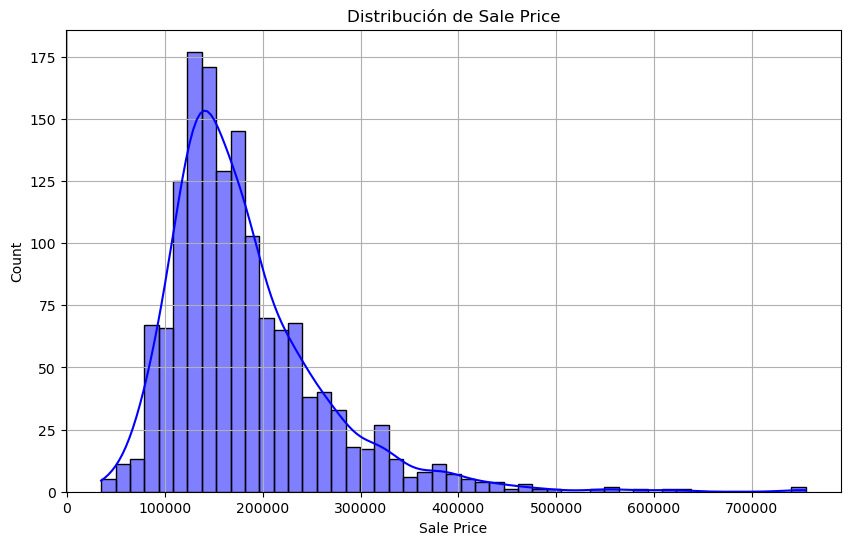

In [ ]:
# Visualizar la distribución de la variable objetivo 'SalePrice'
plt.figure(figsize=(10, 6))
sns.histplot(data['SalePrice'], kde=True, color='blue')
plt.xlabel('Sale Price')
plt.title('Distribución de Sale Price')
plt.grid(True)
plt.show()

In [ ]:
# Asimetría y curtosis:

print("Skewness: %f" % data['SalePrice'].skew())
print("Kurtosis: %f" % data['SalePrice'].kurt())

In [ ]:
# Diagrama de dispersión grlivarea/saleprice:

var = 'GrLivArea'
df1 = pd.concat([data['SalePrice'], data[var]], axis=1)
df1.plot.scatter(x=var, y='SalePrice', alpha = 0.5);

In [ ]:
# Diagrama de dispersión totalbsmtsf/saleprice:

var = 'TotalBsmtSF'
df2 = pd.concat([data['SalePrice'], data[var]], axis=1)
df2.plot.scatter(x=var, y='SalePrice', alpha = 0.5);

Relación con variables categóricas

In [ ]:
# Diagrama de cajas overallqual/saleprice:

var = 'OverallQual'
df3 = pd.concat([data['SalePrice'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

In [ ]:
var = 'YearBuilt'
df4 = pd.concat([data['SalePrice'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

B. Análisis Bivariable

##### Análisis Bivariable de Variables Numéricas

In [ ]:
def top_numeric_analysis(df, target_var, top_n=10):
    # Filtrar solo las columnas numéricas
    numerical_columns = [col for col in df.columns if df[col].dtype != 'object']
    
    # Calcular la correlación solo para las columnas numéricas
    correlations = df[numerical_columns].corr()[target_var].sort_values(ascending=False)
    top_vars = correlations.index[1:top_n+1]  # Excluyendo la primera, que es la propia 'SalePrice'
    
    for var in top_vars:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=var, y=target_var, data=df)
        plt.title(f'Relación entre {var} y {target_var}')
        plt.xlabel(var)
        plt.ylabel(target_var)
        plt.show()
        
        print(f"Correlación entre {var} y {target_var}: {correlations[var]:.2f}\n")

# Llamada a la función
top_numeric_analysis(data, 'SalePrice')

##### Análisis Bivariable de Variables Categóricas

In [ ]:
def top_categorical_analysis(df, target_var, top_n=10):
    categorical_vars = df.select_dtypes(include=['object']).columns
    avg_target_by_cat = {}

    # Calcular la media de la variable objetivo para cada variable categórica
    for var in categorical_vars:
        if df[var].nunique() < 20:  # Limitar el análisis a variables con pocas categorías
            mean_target = df.groupby(var)[target_var].mean().mean()
            avg_target_by_cat[var] = mean_target

    # Seleccionar las 10 variables categóricas con mayor impacto promedio en la variable objetivo
    top_cats = sorted(avg_target_by_cat, key=avg_target_by_cat.get, reverse=True)[:top_n]

    for var in top_cats:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=var, y=target_var, data=df)
        plt.title(f'Relación entre {var} y {target_var}')
        plt.xlabel(var)
        plt.ylabel(target_var)
        plt.xticks(rotation=45)
        plt.show()

# Llamada a la función
top_categorical_analysis(data, 'SalePrice')

C. Análisis Multivariable

Análisis de Componentes Principales (PCA)

Dado que los datos pueden tener una alta dimensionalidad, se aplica PCA para reducir la cantidad de variables manteniendo la mayor parte de la varianza. Esto ayuda a simplificar el modelo y evita problemas de multicolinealidad.

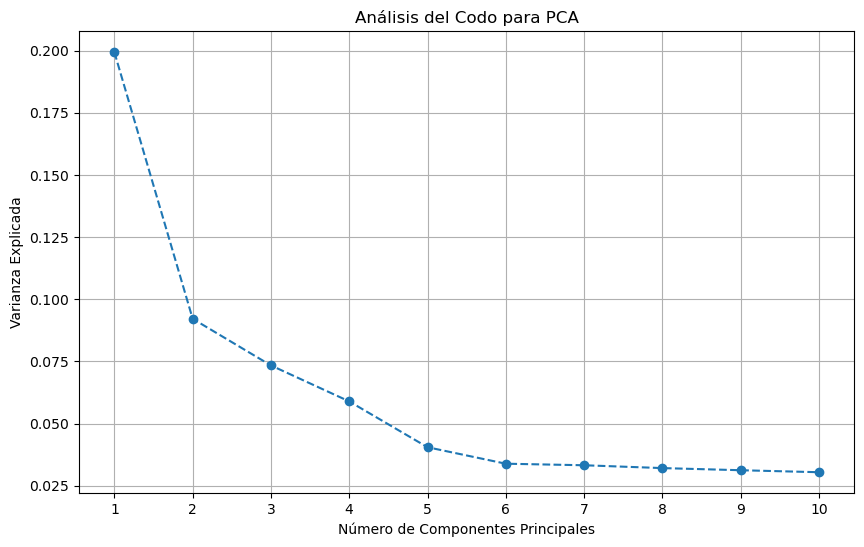

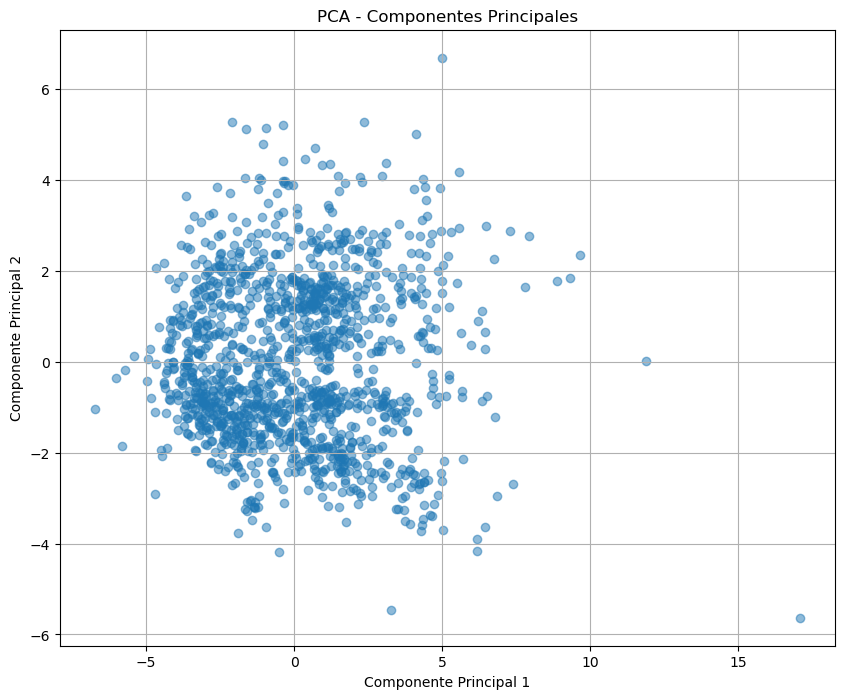

Varianza explicada por cada componente: [0.1993644  0.09215957 0.07339994 0.05893024 0.04050391 0.0338748
 0.03325119 0.03211349 0.0312534  0.03045046]


In [182]:
# Análisis Multivariable

# Seleccion de las columnas numéricas
numerical_data = data.select_dtypes(include=['float64', 'int64']).drop(columns=['Id', 'SalePrice'], errors='ignore')

# Estandarizar los datos numéricos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numerical_data)

# Aplicar PCA y reducir a 10 componentes principales
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Graficar el análisis del codo
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Análisis del Codo para PCA')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

# Graficar los componentes principales
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA - Componentes Principales')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid()
plt.show()

# Explicación de la varianza
explained_variance = pca.explained_variance_ratio_
print(f"Varianza explicada por cada componente: {explained_variance}")


Ingeniería y Selección de Características usando RFE y el Factor de Inflación de Varianza

In [184]:
# Análisis Multivariable (verificacion de mejores componentes con catboost N = 5)

# Preparar los datos
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Manejo de características categóricas
feature_names = list(X_train.columns)
cat_features = [column for column, dtype in X_train.dtypes.items() if dtype == 'object']

# Rellenar valores faltantes en características categóricas
X_train[cat_features] = X_train[cat_features].fillna('NA')
X_test[cat_features] = X_test[cat_features].fillna('NA')

# Crear Pool para CatBoost
dataset_train_pool = Pool(X_train, y_train, feature_names=feature_names, cat_features=cat_features)
dataset_test_pool = Pool(X_test, y_test, feature_names=feature_names, cat_features=cat_features)

# Función para seleccionar características
def select_features_dataset(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostRegressor(iterations=500, random_seed=0)
    summary = model.select_features(
        dataset_train_pool,
        eval_set=dataset_test_pool,
        features_for_select=list(range(dataset_train_pool.num_col())),
        num_features_to_select=10,  # Numero de Componentes
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

# Ejecutar selección de características usando el algoritmo basado en SHAP
dataset_shap_summary = select_features_dataset(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=3)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['LotArea', 'Neighborhood', 'OverallQual', 'YearRemodAdd', 'ExterQual', 'BsmtFinSF1', 'GrLivArea', 'GarageYrBlt', 'GarageFinish', 'GarageArea']


In [195]:
_ = select_features_dataset(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=9)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['MSZoning', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'GrLivArea', 'BsmtFullBath', 'GarageType', 'GarageCars', 'SaleCondition']


Factor de Inflación de Varianza (VIF)

El Factor de Inflación de Varianza (VIF) es una medida que indica cuánto la varianza de un coeficiente de una variable se inflaría debido a la multicolinealidad con otras variables. Un VIF alto sugiere que la variable está altamente correlacionada con otras variables en el modelo, lo que puede afectar la estabilidad de los coeficientes.

Interpretación de los resultados:
VIF ≈ 1: No hay correlación entre la variable y las demás.
1 < VIF < 5: Correlación moderada, generalmente aceptable.
VIF > 5: Correlación alta, puede ser problemático.
VIF > 10: Correlación muy alta, se recomienda considerar eliminar la variable.

In [203]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from tabulate import tabulate

# Supongamos que 'data' es tu DataFrame original
# Convertir variables categóricas a variables dummy
data_encoded = pd.get_dummies(data, drop_first=True)

# Seleccionar solo las variables numéricas y eliminar valores nulos
numerical_df = data_encoded.select_dtypes(include=[np.number]).dropna()

# Agregar una constante para calcular el VIF
X = add_constant(numerical_df)

# Calcular el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Función para interpretar los valores de VIF
def interpret_vif(vif):
    if vif == 1:
        return "No hay correlación"
    elif 1 < vif < 5:
        return "Correlación moderada, generalmente aceptable"
    elif 5 <= vif <= 10:
        return "Correlación alta, puede ser problemático"
    else:
        return "Correlación muy alta, se recomienda considerar eliminar la variable"

# Aplicar la función de interpretación a la columna VIF
vif_data["Correlación"] = vif_data["VIF"].apply(interpret_vif)


# Ajustar las opciones de visualización de pandas para mostrar toda la tabla
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Mostrar resultados en una tabla usando tabulate
print(tabulate(vif_data, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═══════════════╤═══════════════╤═════════════════════════════════════════════════════════════════════╕
│ Variable      │           VIF │ Correlación                                                         │
╞═══════════════╪═══════════════╪═════════════════════════════════════════════════════════════════════╡
│ const         │   2.41049e+06 │ Correlación muy alta, se recomienda considerar eliminar la variable │
├───────────────┼───────────────┼─────────────────────────────────────────────────────────────────────┤
│ MSSubClass    │   1.54105     │ Correlación moderada, generalmente aceptable                        │
├───────────────┼───────────────┼─────────────────────────────────────────────────────────────────────┤
│ LotArea       │   1.2328      │ Correlación moderada, generalmente aceptable                        │
├───────────────┼───────────────┼─────────────────────────────────────────────────────────────────────┤
│ OverallQual   │   3.62161     │ Correlación moderada, generalm

### 6. Preparacion de datos

A. Eleccion y conversion de variables

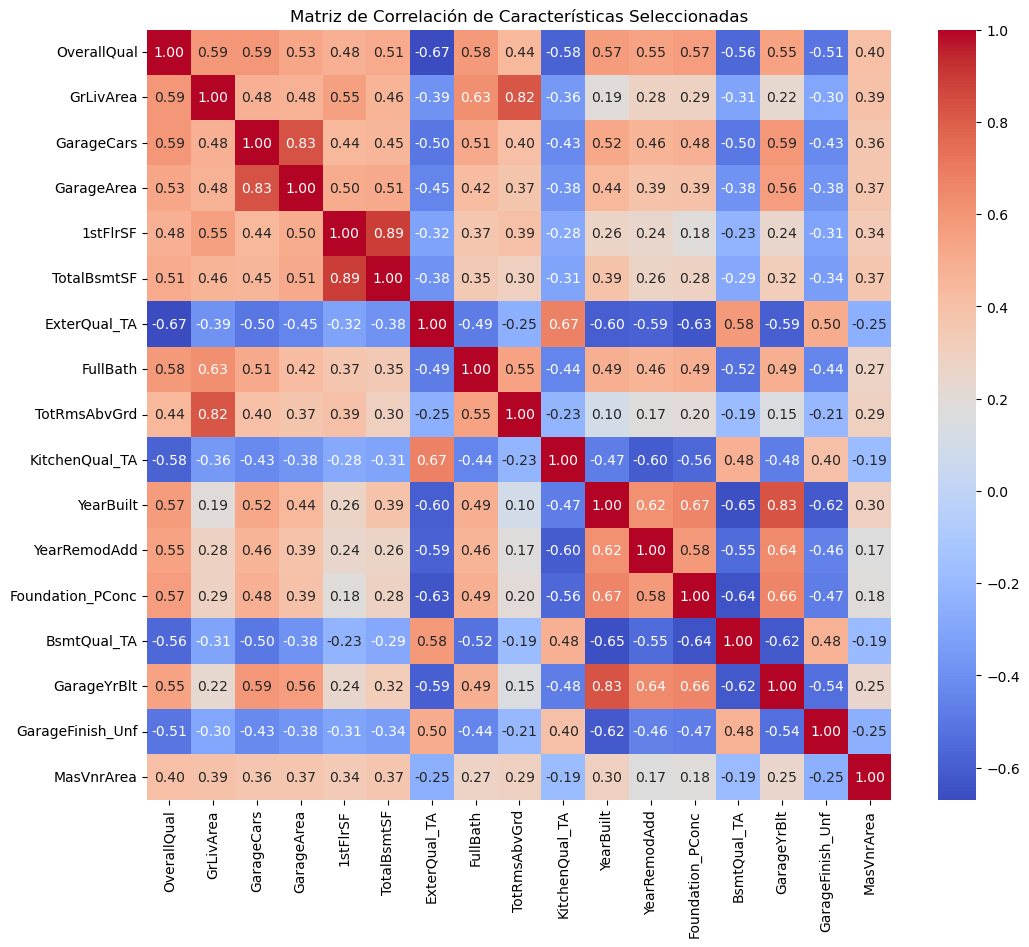

In [188]:
pd.options.display.float_format = '{:.2f}'.format

# Convertir variables categóricas en variables numéricas usando One-Hot Encoding
data_encoded = pd.get_dummies(data, drop_first=True)

# Definir variable objetivo y características
X = data_encoded.drop('SalePrice', axis=1, errors='ignore')
y = data_encoded['SalePrice']

# Selección basada en correlación (>0.45 con SalePrice)
correlation_matrix = data_encoded.corr()
correlation_with_target = correlation_matrix['SalePrice'].abs().sort_values(ascending=False)
correlated_features = correlation_with_target[correlation_with_target > 0.45].index.tolist()
correlated_features.remove('SalePrice')

# Graficar la matriz de correlación
plt.figure(figsize=(12, 10))
selected_corr_matrix = data_encoded[correlated_features].corr()
sns.heatmap(selected_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación de Características Seleccionadas")
plt.show()

B. Splitting data into Train Test

In [189]:
# Dividir Datos en Train y Test
X_selected = data_encoded[correlated_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 7. Construccion de los Modelos

#### A. Linear Regression

Sirve como un modelo base simple, donde se asume una relación lineal directa entre las variables predictoras y el precio. Este modelo es útil como referencia para evaluar el impacto de las técnicas de regularización.

Linear Regression - Train R^2: 0.77
Linear Regression - Test R^2: 0.76
Linear Regression - RMSE: 32360.84
Linear Regression - MAE: 24467.77


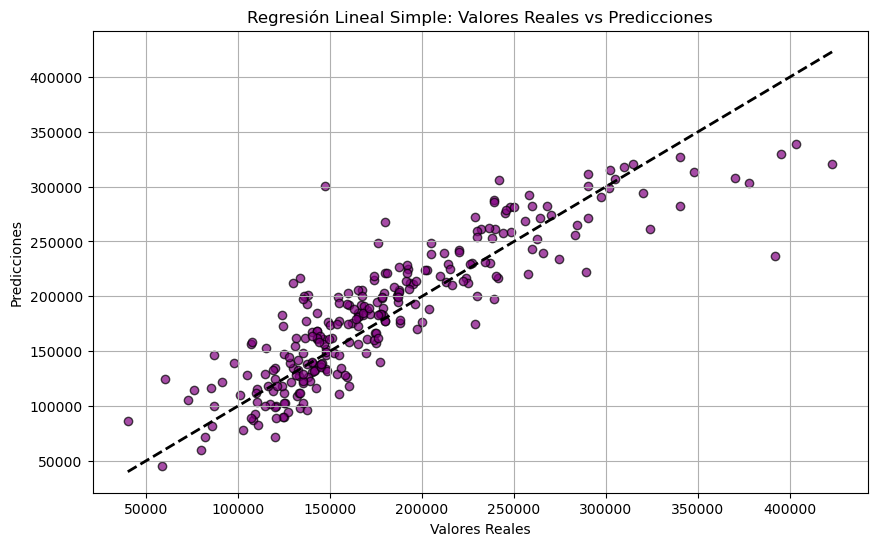

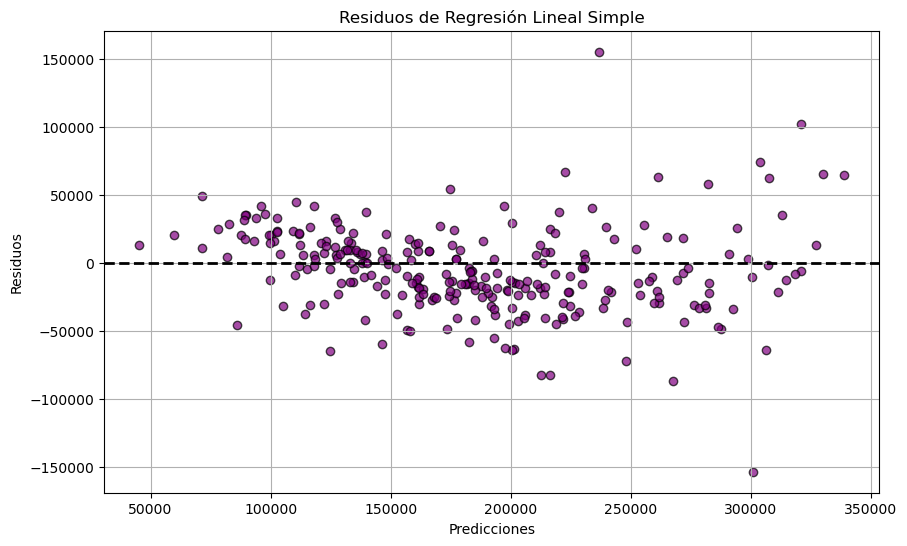

In [190]:
# Regresión Lineal Simple
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Realizar predicciones y evaluar el modelo
y_test_pred_linear = linear_model.predict(X_test_scaled)
train_r2_linear = r2_score(y_train, linear_model.predict(X_train_scaled))
test_r2_linear = r2_score(y_test, y_test_pred_linear)

# Calcular RMSE
rmse_linear = np.sqrt(mean_squared_error(y_test, y_test_pred_linear))

# Calcular MAE
mae_linear = mean_absolute_error(y_test, y_test_pred_linear)

# Imprimir resultados
print(f'Linear Regression - Train R^2: {train_r2_linear:.2f}')
print(f'Linear Regression - Test R^2: {test_r2_linear:.2f}')
print(f'Linear Regression - RMSE: {rmse_linear:.2f}')
print(f'Linear Regression - MAE: {mae_linear:.2f}')

# Visualización Regresión Lineal Simple
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_linear, color='purple', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Regresión Lineal Simple: Valores Reales vs Predicciones')
plt.grid(True)
plt.show()

# Graficar residuos para Regresión Lineal
residuals_linear = y_test - y_test_pred_linear
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_linear, residuals_linear, color='purple', edgecolor='k', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Residuos de Regresión Lineal Simple')
plt.grid(True)
plt.show()



#### B. Ridge Regression

Este modelo añade una penalización para reducir los coeficientes de variables con alta colinealidad, lo cual ayuda a mejorar la estabilidad y generalización del modelo.

Ridge - Mejor valor de alpha: 323.75
Ridge - R² Score Train: 0.76
Ridge - R² Score Test: 0.75
Ridge - RMSE Test: 32607.36


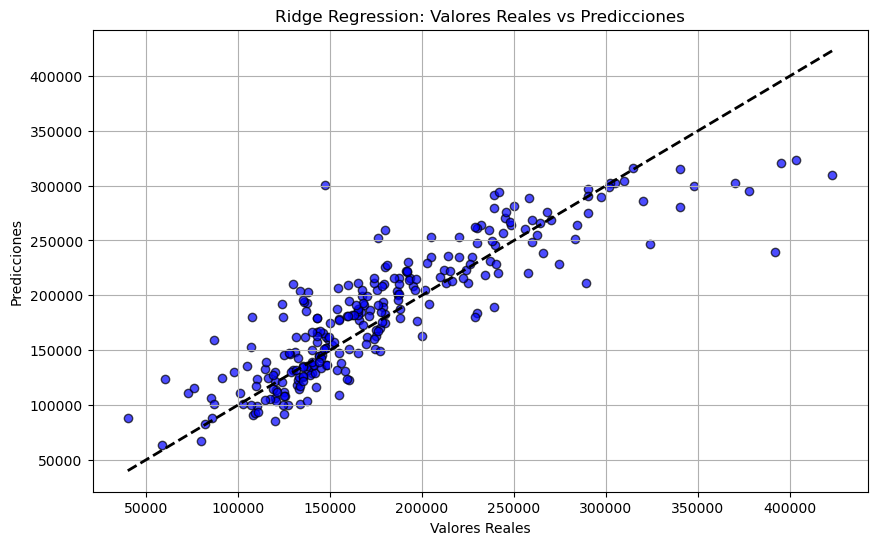

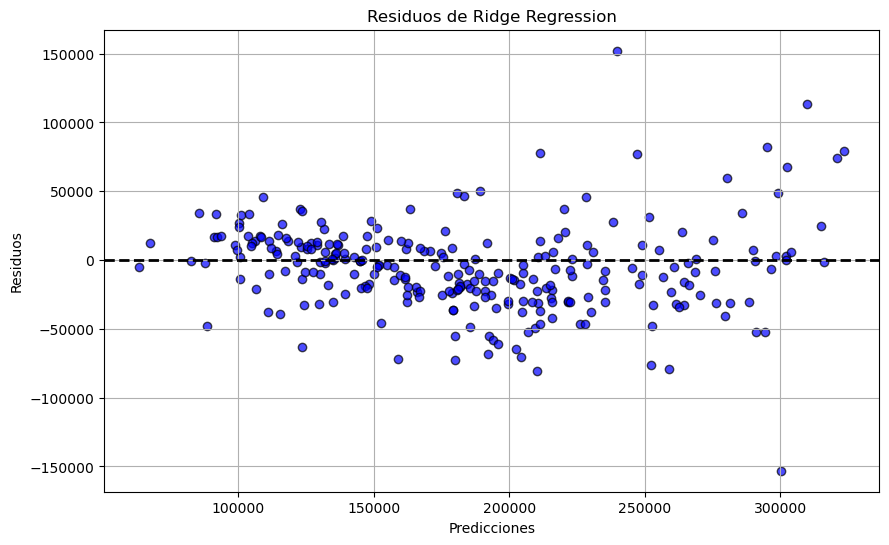

In [191]:
# Ridge Regression
# Configurar el modelo Ridge con GridSearchCV para encontrar el mejor alpha
alpha_range = np.logspace(-3, 3, 50)
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, param_grid={'alpha': alpha_range}, cv=5, scoring='r2')
ridge_cv.fit(X_train_scaled, y_train)

# Obtener el mejor alpha y evaluar el modelo
best_alpha_ridge = ridge_cv.best_params_['alpha']
ridge_best_model = ridge_cv.best_estimator_
y_test_pred_ridge = ridge_best_model.predict(X_test_scaled)

# Evaluar Ridge
mse_ridge = mean_squared_error(y_test, y_test_pred_ridge)
r2_ridge_train = r2_score(y_train, ridge_best_model.predict(X_train_scaled))
r2_ridge_test = r2_score(y_test, y_test_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

# Imprimir resultados
print(f"Ridge - Mejor valor de alpha: {best_alpha_ridge:.2f}")
print(f"Ridge - R² Score Train: {r2_ridge_train:.2f}")
print(f"Ridge - R² Score Test: {r2_ridge_test:.2f}")
print(f"Ridge - RMSE Test: {rmse_ridge:.2f}")

# Visualización Ridge
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_ridge, color='blue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Ridge Regression: Valores Reales vs Predicciones')
plt.grid(True)
plt.show()

# Graficar residuos para Ridge
residuals_ridge = y_test - y_test_pred_ridge
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_ridge, residuals_ridge, color='blue', edgecolor='k', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Residuos de Ridge Regression')
plt.grid(True)
plt.show()


#### C. Lasso Regression

Además de la regularización, Lasso tiene la capacidad de reducir algunos coeficientes a cero, eliminando variables irrelevantes del modelo. Esto permite una simplificación adicional y ayuda en la selección de características.

Lasso - Optimal Lambda Value: 1000.00
Lasso - Train R²: 0.77
Lasso - Test R²: 0.76
Lasso - RMSE Test: 32197.50


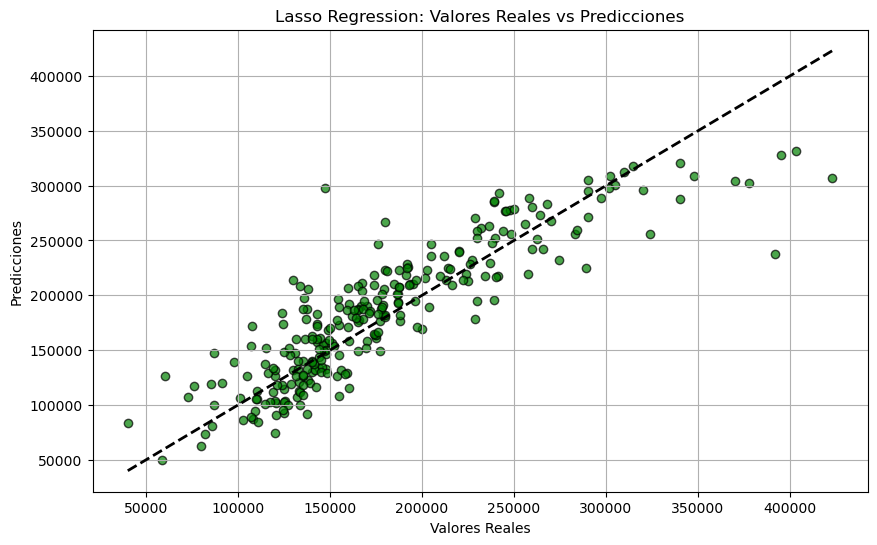

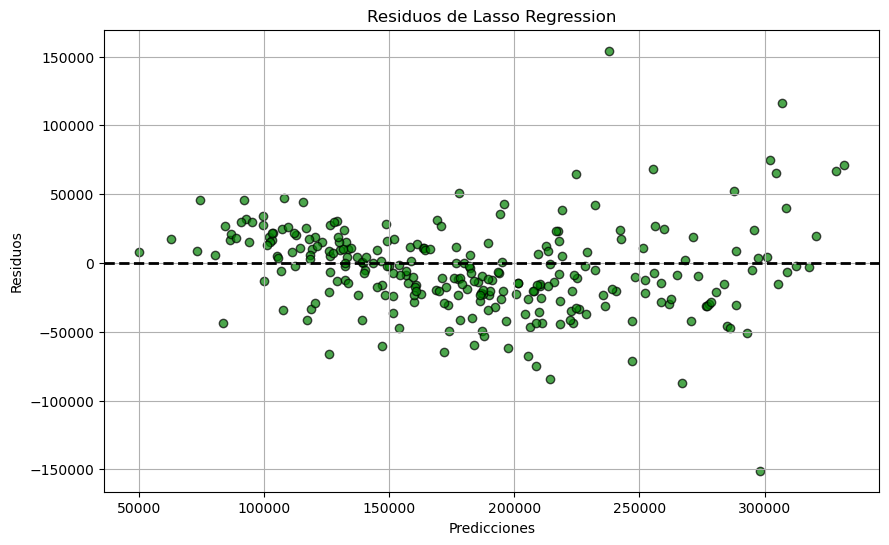

In [192]:
# Rango de alpha para el GridSearch
alpha_range = np.logspace(-3, 3, 50)  # Valores de alpha entre 0.001 y 1000

# Configurar el modelo Lasso
lasso = Lasso()

# Configurar GridSearchCV para encontrar el mejor alpha
lasso_cv = GridSearchCV(lasso, param_grid={'alpha': alpha_range}, cv=5, scoring='r2')
lasso_cv.fit(X_train_scaled, y_train)

# Obtener el mejor alpha y ajustar el modelo
best_alpha_lasso = lasso_cv.best_params_['alpha']
lasso_best_model = lasso_cv.best_estimator_

# Realizar predicciones y evaluar el modelo
y_test_pred_lasso = lasso_best_model.predict(X_test_scaled)
train_r2_lasso = r2_score(y_train, lasso_best_model.predict(X_train_scaled))
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)

# Calcular RMSE
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))

# Imprimir resultados
print(f'Lasso - Optimal Lambda Value: {best_alpha_lasso:.2f}')
print(f'Lasso - Train R²: {train_r2_lasso:.2f}')
print(f'Lasso - Test R²: {test_r2_lasso:.2f}')
print(f'Lasso - RMSE Test: {rmse_lasso:.2f}')

# Visualización Lasso
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lasso, color='green', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Lasso Regression: Valores Reales vs Predicciones')
plt.grid(True)
plt.show()

# Graficar residuos para Lasso
residuals_lasso = y_test - y_test_pred_lasso
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lasso, residuals_lasso, color='green', edgecolor='k', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Residuos de Lasso Regression')
plt.grid(True)
plt.show()



#### D. Elastic Net

Combina las penalizaciones de Ridge y Lasso para obtener los beneficios de ambas, especialmente útil en conjuntos de datos con muchas variables correlacionadas.

ElasticNet - Optimal Alpha Value: 0.66
ElasticNet - Optimal L1 Ratio: 0.33
ElasticNet - Train R²: 0.76
ElasticNet - Test R²: 0.75
ElasticNet - RMSE Test: 32770.21


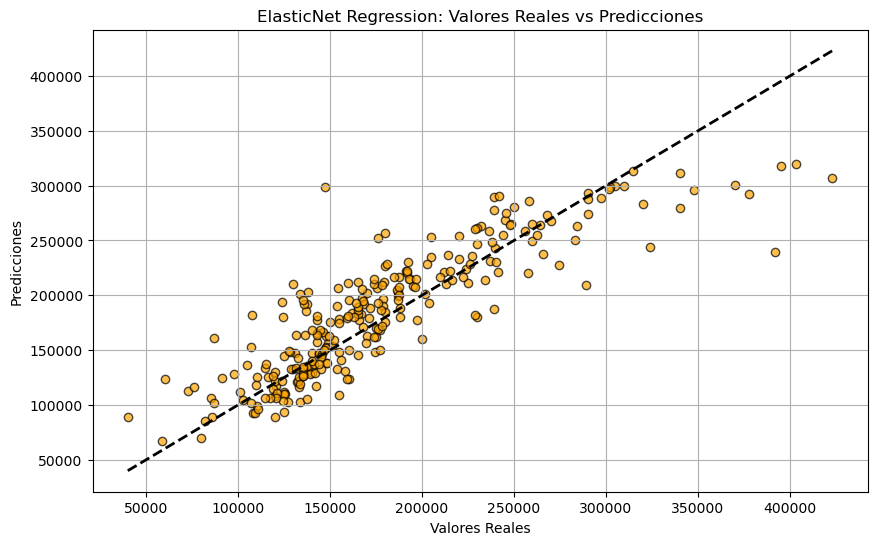

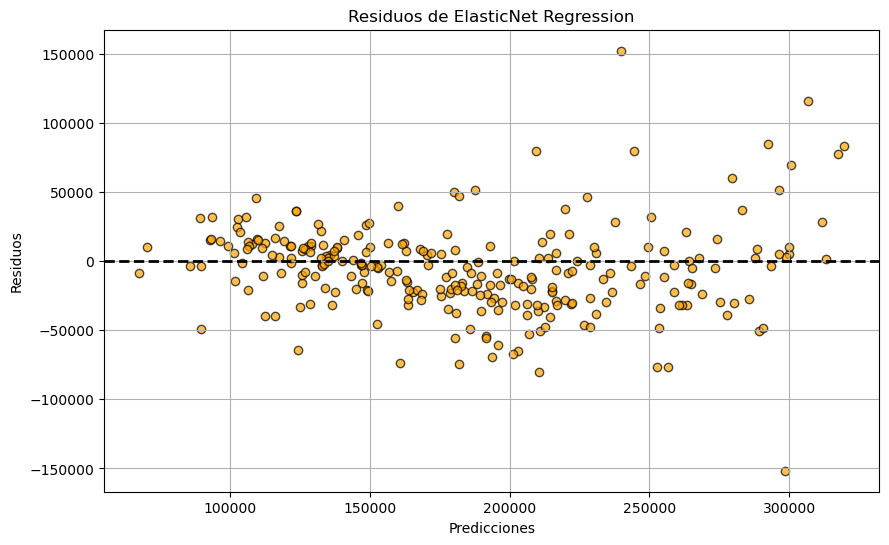

In [193]:
# Rango de alpha y l1_ratio para el GridSearch
alpha_range = np.logspace(-3, 3, 50)  # Valores de alpha entre 0.001 y 1000
l1_ratio_range = np.linspace(0, 1, 10)  # Valores de l1_ratio entre 0 y 1

# Configurar el modelo ElasticNet
elastic_net = ElasticNet()

# Configurar GridSearchCV para encontrar los mejores parámetros
param_grid = {'alpha': alpha_range, 'l1_ratio': l1_ratio_range}
elastic_net_cv = GridSearchCV(elastic_net, param_grid, cv=5, scoring='r2')
elastic_net_cv.fit(X_train_scaled, y_train)

# Obtener el mejor alpha y l1_ratio y ajustar el modelo
best_alpha_en = elastic_net_cv.best_params_['alpha']
best_l1_ratio_en = elastic_net_cv.best_params_['l1_ratio']
elastic_net_best_model = elastic_net_cv.best_estimator_

# Realizar predicciones y evaluar el modelo
y_test_pred_en = elastic_net_best_model.predict(X_test_scaled)
train_r2_en = r2_score(y_train, elastic_net_best_model.predict(X_train_scaled))
test_r2_en = r2_score(y_test, y_test_pred_en)

# Calcular RMSE
rmse_en = np.sqrt(mean_squared_error(y_test, y_test_pred_en))

# Imprimir resultados
print(f'ElasticNet - Optimal Alpha Value: {best_alpha_en:.2f}')
print(f'ElasticNet - Optimal L1 Ratio: {best_l1_ratio_en:.2f}')
print(f'ElasticNet - Train R²: {train_r2_en:.2f}')
print(f'ElasticNet - Test R²: {test_r2_en:.2f}')
print(f'ElasticNet - RMSE Test: {rmse_en:.2f}')

# Visualización ElasticNet
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_en, color='orange', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('ElasticNet Regression: Valores Reales vs Predicciones')
plt.grid(True)
plt.show()

# Graficar residuos para ElasticNet
residuals_en = y_test - y_test_pred_en
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_en, residuals_en, color='orange', edgecolor='k', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Residuos de ElasticNet Regression')
plt.grid(True)
plt.show()


Justificación:
Se utiliza GridSearchCV para optimizar los hiperparámetros de los modelos de regresión (ElasticNet, Lasso y Ridge). Este proceso permite explorar de manera sistemática diferentes combinaciones de valores de hiperparámetros, como alpha y l1_ratio, en lugar de seleccionar valores de forma arbitraria. La búsqueda de los mejores hiperparámetros maximiza el rendimiento del modelo al seleccionar aquellos valores que proporcionan el mayor puntaje de R² en validación cruzada. De esta manera, se mejora la precisión y la generalización del modelo, evitando tanto el sobreajuste como el subajuste.

### 8. Conclusiones

In [199]:
from tabulate import tabulate

comparison_data = {
    "Modelo": ["ElasticNet", "Lasso", "Ridge", "Linear Regression"],
    "Alpha (λ)": [best_alpha_en, best_alpha_lasso, best_alpha_ridge, "N/A"],
    "L1 Ratio (ElasticNet)": [best_l1_ratio_en, "N/A", "N/A", "N/A"],
    "Train R²": [train_r2_en, train_r2_lasso, r2_ridge_train, train_r2_linear],
    "Test R²": [test_r2_en, test_r2_lasso, r2_ridge_test, test_r2_linear],
    "RMSE": [rmse_en, rmse_lasso, rmse_ridge, rmse_linear],
    "MAE": ["N/A", "N/A", "N/A", mae_linear]  # MAE solo para Regresión Lineal Simple
}

metrics_comparison_df = pd.DataFrame(comparison_data)
print(tabulate(metrics_comparison_df, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═══════════════════╤═══════════════════╤═════════════════════════╤════════════╤═══════════╤═════════╤════════════════════╕
│ Modelo            │ Alpha (λ)         │ L1 Ratio (ElasticNet)   │   Train R² │   Test R² │    RMSE │ MAE                │
╞═══════════════════╪═══════════════════╪═════════════════════════╪════════════╪═══════════╪═════════╪════════════════════╡
│ ElasticNet        │ 0.655128556859551 │ 0.3333333333333333      │   0.757374 │  0.74904  │ 32770.2 │ N/A                │
├───────────────────┼───────────────────┼─────────────────────────┼────────────┼───────────┼─────────┼────────────────────┤
│ Lasso             │ 1000.0            │ N/A                     │   0.770372 │  0.757735 │ 32197.5 │ N/A                │
├───────────────────┼───────────────────┼─────────────────────────┼────────────┼───────────┼─────────┼────────────────────┤
│ Ridge             │ 323.745754281764  │ N/A                     │   0.762457 │  0.751528 │ 32607.4 │ N/A                │
├───────

El mercado inmobiliario en Australia enfrenta grandes desafíos debido a las fluctuaciones de precios influenciadas por la ubicación, características de las propiedades y factores económicos. Esto hace que sea complicado para inversionistas y empresas predecir precios y planificar estrategias efectivas. Sin herramientas adecuadas, el riesgo en la toma de decisiones aumenta y la competitividad disminuye.

Este proyecto se centró en desarrollar un modelo de predicción de precios de viviendas que pueda ayudar a las empresas e inversionistas a tomar decisiones más informadas. Los resultados de los modelos de regresión fueron los siguientes:

Regresión Lineal: Logró un R² de 0.77 en el entrenamiento y 0.76 en la prueba, con un RMSE de 32,360.84. Esto indica un buen ajuste, pero también espacio para mejoras.

Regresión Ridge: Con un alpha óptimo de 323.75, obtuvo un R² de 0.76 en entrenamiento y 0.75 en prueba, con un RMSE de 32,607.36. Mostró eficacia al reducir el sobreajuste.

Regresión Lasso: Encontró un lambda óptimo de 1,000.00, logrando un R² de 0.77 en entrenamiento y 0.76 en prueba, y un RMSE de 32,197.50. Este modelo también ayudó a reducir el número de características, facilitando su interpretación.

Regresión ElasticNet: Usando un alpha de 0.66 y un l1_ratio de 0.33, logró un R² de 0.76 y un RMSE de 32,770.21. Combinó los beneficios de Ridge y Lasso, seleccionando características relevantes y manteniendo un buen rendimiento.

Las variables más significativas identificadas fueron OverallQual, YearRemodAdd, ExterQual, TotalBsmtSF y GrLivArea. Esto sugiere que la calidad general, remodelaciones y el tamaño del área son factores clave en la fijación de precios.

Con un modelo predictivo efectivo, los inversionistas pueden tomar decisiones más acertadas, adaptando sus estrategias a lo que realmente influye en el valor de las propiedades. Esto no solo mejora la asignación de recursos, sino que también reduce riesgos.